# Подключение библиотек 

In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import regex as re
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import model_selection
import parfit.parfit as pf
from wordcloud import WordCloud, STOPWORDS

# Загрузка данных

In [2]:
# В данном случае параметр «./Data/train» указывает на имя папки, в которой будет находиться наша обучающая выборка 
reviews_train = load_files("./Data/train")
text_train, y_train = reviews_train.data, reviews_train.target
df_train = pd.concat((pd.DataFrame(reviews_train.data), 
                     pd.DataFrame(reviews_train.target)), axis=1)
df_train.columns = ['review','target']
df_train['review'] = df_train['review'].astype(str)

In [3]:
# Загрузка тестовых данных 
reviews_test = load_files("./Data/test")
text_test, y_test = reviews_test.data, reviews_test.target
df_test = pd.concat((pd.DataFrame(reviews_test.data), 
                     pd.DataFrame(reviews_test.target)), axis=1)
df_test.columns = ['review','target']
df_test['review'] = df_test['review'].astype(str)

# Очистка данных

In [4]:
stop_words = stopwords.words('english')
#Удаляем из стоп-слов частицу not, так как она влияет на окраску рецензии
stop_words.remove('not')
lemmatizer = WordNetLemmatizer()

In [5]:
def clean_review(review):
    review = re.sub(re.compile('<.*?>'),'',review)
    review = re.sub('[^A-Za-z0-9]+',' ', review)
    review = review.lower()
    
    tokens = nltk.word_tokenize(review)
    
    review = [word for word in tokens if word not in stop_words]
    review = [lemmatizer.lemmatize(word) for word in review]
    
    review = ' '.join(review)
    
    return review

In [6]:
df_train['clean_review'] = df_train['review'].apply(lambda x: clean_review(x))
df_test['clean_review'] = df_test['review'].apply(lambda x: clean_review(x))

# Облако слов 

In [9]:
cv = CountVectorizer()
cv.fit(text_train)

CountVectorizer()

In [10]:
for i,j in zip(df_train['clean_review'], y_train):
    if j == 1:
        str_one_pos = " " + str(i) # формирование одной строки из списка комментариев 
    if j == 0:
        str_one_neg = " " + str(i)   

In [11]:
text_list = list(cv.vocabulary_.keys())
stopwords = set(STOPWORDS)
wordcloud1 = WordCloud(width = 800, height = 800,background_color ='white',stopwords = stopwords,min_font_size = 10).generate(str_one_pos) 
wordcloud2 = WordCloud(width = 800, height = 800,background_color ='white',stopwords = stopwords, min_font_size = 10).generate(str_one_neg) 

(-0.5, 799.5, 799.5, -0.5)

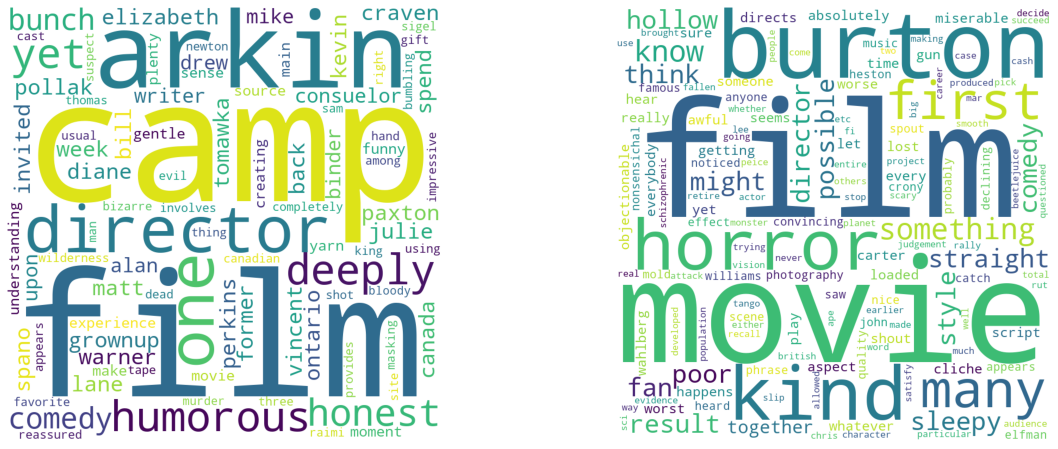

In [12]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.imshow(wordcloud1); ax1.axis("off")
ax2.imshow(wordcloud2); ax2.axis("off")

# Определение базовой модели

Для дальнейшей работы нам необходимо составить словарь уникальных слов, используемых в обучающей выборке. 
Для этого используется метод CountVectorizer

Преобразование соварей текстов в векторную форму 

In [13]:
# BOW
cv = CountVectorizer()
X_train_bow = cv.fit_transform(df_train['clean_review'])
X_test_bow = cv.transform(df_test['clean_review'])
print(X_train_bow.shape)
print(X_test_bow.shape)

(25000, 68458)
(25000, 68458)


In [14]:
# Tfid
tfv = TfidfVectorizer()
X_train_tfid = tfv.fit_transform(df_train['clean_review'])
X_test_tfid = tfv.transform(df_test['clean_review'])
print(X_train_tfid.shape)
print(X_test_tfid.shape)

(25000, 68458)
(25000, 68458)


##  Логистическая регрессия

## BOW

In [15]:
log_reg = LogisticRegression(penalty='l2', random_state=10, max_iter = 1000)
log_reg.fit(X_train_bow, y_train)

LogisticRegression(max_iter=1000, random_state=10)

In [16]:
predicted_log = log_reg.predict(X_test_bow)
print("Accuracy: ", metrics.accuracy_score(y_test, predicted_log))

Accuracy:  0.85972


### TF-IDF

In [17]:
log_reg.fit(X_train_tfid, y_train)

LogisticRegression(max_iter=1000, random_state=10)

In [18]:
predicted_log = log_reg.predict(X_test_tfid)
print("Accuracy: ", metrics.accuracy_score(y_test, predicted_log))

Accuracy:  0.87996


## K-ближайших соседей

### BOW

In [19]:
knei_class = KNeighborsClassifier(n_neighbors=10)
knei_class.fit(X_train_bow, y_train)

KNeighborsClassifier(n_neighbors=10)

In [20]:
predicted_knei = knei_class.predict(X_test_bow)
print("Accuracy: ", metrics.accuracy_score(y_test, predicted_knei))

Accuracy:  0.63116


### TF-IDF

In [21]:
knei_class.fit(X_train_tfid, y_train)

KNeighborsClassifier(n_neighbors=10)

In [22]:
predicted_knei = knei_class.predict(X_test_tfid)
print("Accuracy: ", metrics.accuracy_score(y_test, predicted_knei))

Accuracy:  0.6706


## Рандомный лес

### BOW

In [23]:
rf_class = RandomForestClassifier()
rf_class.fit(X_train_bow, y_train)

RandomForestClassifier()

In [24]:
predicted_rf = rf_class.predict(X_test_bow)
print("Accuracy: ", metrics.accuracy_score(y_test, predicted_rf))

Accuracy:  0.85112


### TF-IDF

In [25]:
rf_class.fit(X_train_tfid, y_train)

RandomForestClassifier()

In [26]:
predicted_rf  = rf_class.predict(X_test_tfid)
print("Accuracy: ", metrics.accuracy_score(y_test, predicted_rf ))

Accuracy:  0.8474


## Наивный байесовский классификатор

### BOW

In [27]:
nb_class = MultinomialNB()
nb_class.fit(X_train_bow, y_train)

MultinomialNB()

In [28]:
predicted_nb = nb_class.predict(X_test_bow)
print("Accuracy: ", metrics.accuracy_score(y_test, predicted_nb))

Accuracy:  0.821


### TF-IDF

In [29]:
nb_class.fit(X_train_tfid, y_train)

MultinomialNB()

In [30]:
predicted_nb  = nb_class.predict(X_test_tfid)
print("Accuracy: ", metrics.accuracy_score(y_test, predicted_nb))

Accuracy:  0.83064


## Cтохастический градиентный спуск 

### BOW

In [31]:
sgd_class = SGDClassifier(random_state=42, max_iter = 1000)
sgd_class.fit(X_train_bow, y_train)

SGDClassifier(random_state=42)

In [32]:
predicted_sgd = sgd_class.predict(X_test_bow)
print("Accuracy: ", metrics.accuracy_score(y_test, predicted_sgd))

Accuracy:  0.8448


### TF-IDF

In [33]:
sgd_class.fit(X_train_tfid, y_train)

SGDClassifier(random_state=42)

In [34]:
predicted_sgd = sgd_class.predict(X_test_tfid)
print("Accuracy: ", metrics.accuracy_score(y_test, predicted_sgd))

Accuracy:  0.88004


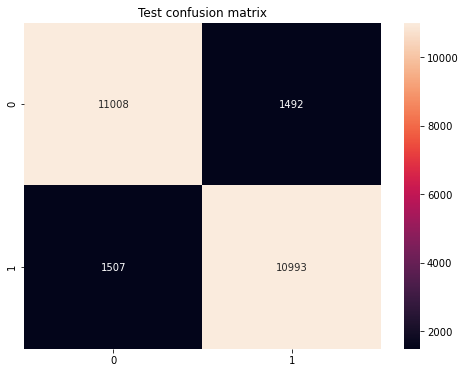

In [35]:
cm = metrics.confusion_matrix(y_test, predicted_sgd)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test confusion matrix')
plt.show()

Таким образом, наилучший результат выдает 

## Улучшение модели

In [36]:
stop_words.append('film')
stop_words.append('movie')

In [37]:
#df_train['clean_review'] = df_train['review'].apply(lambda x: clean_review(x))
#df_test['clean_review'] = df_test['review'].apply(lambda x: clean_review(x))

In [43]:
tfv = TfidfVectorizer()
X_train_tfid = tfv.fit_transform(df_train['clean_review'])
X_test_tfid = tfv.transform(df_test['clean_review'])
print(X_train_tfid.shape)
print(X_test_tfid.shape)

(25000, 68458)
(25000, 68458)


In [44]:
sgd_class = SGDClassifier( max_iter = 1000, 
                          loss = 'log', penalty = 'l2', 
                          n_jobs = -1, alpha = 1e-4)

In [45]:
sgd_class.fit(X_train_tfid, y_train)

SGDClassifier(loss='log', n_jobs=-1)

In [46]:
predicted_sgd = sgd_class.predict(X_test_tfid)
print("Accuracy: ", metrics.accuracy_score(y_test, predicted_sgd))

Accuracy:  0.87544


Воспользуемся другой бибилиотекой для нахождения оптимального значения альфа

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.5s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.2s finished


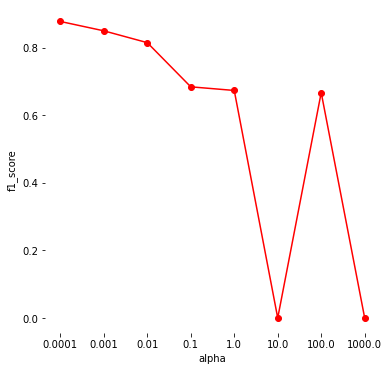

SGDClassifier(loss='log', n_jobs=-1) 0.8771057718862192


In [48]:
grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'max_iter': [1000], # number of epochs
    'loss': ['log'], # logistic regression,
    'penalty': ['l2'],
    'n_jobs': [-1]
}
paramGrid = model_selection.ParameterGrid(grid)

bestModel, bestScore, allModels, allScores = pf.bestFit(SGDClassifier, 
            paramGrid,
           X_train_tfid, y_train, X_test_tfid, y_test, 
           metric = metrics.f1_score,
           scoreLabel = "f1_score")

print(bestModel, bestScore)

In [51]:
grid = {
    'max_iter': [1000], # number of epochs
    'penalty': ['l2'],
    'n_jobs': [-1]
}
paramGrid = model_selection.ParameterGrid(grid)

bestModel, bestScore, allModels, allScores = pf.bestFit(LogisticRegression, 
            paramGrid,
           X_train_tfid, y_train, X_test_tfid, y_test, 
           metric = metrics.f1_score,
           scoreLabel = "f1_score")

print(bestModel, bestScore)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------
No parameters that vary in the grid
LogisticRegression(max_iter=1000, n_jobs=-1) 0.8798590816285681


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished
